In [48]:
# load libraries
import os
import pandas as pd
import numpy as np
import yfinance as yf
import praw
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import statsmodels.api as sm
from datetime import datetime, timedelta
from dotenv import load_dotenv

In [50]:
# download Tesla stock data
data = yf.download('TSLA', start='2023-01-01', end='2023-12-31')
data.columns = ['Close_TSLA', 'High_TSLA', 'Low_TSLA', 'Open_TSLA', 'Volume_TSLA']
data['Return'] = data['Close_TSLA'].pct_change().shift(-1)
data.dropna(inplace=True)
data.head()

/var/folders/yz/c85pt_fs2c36sr4h_scpn7280000gn/T/ipykernel_21319/79870599.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('TSLA', start='2023-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


,Close_TSLA,High_TSLA,Low_TSLA,Open_TSLA,Volume_TSLA,Return
Date,,,,,,
2023-01-03,108.099998,118.800003,104.639999,118.470001,231402800,0.051249
2023-01-04,113.639999,114.589996,107.519997,109.110001,180389000,-0.029039
2023-01-05,110.339996,111.750000,107.160004,110.510002,157986300,0.024651
2023-01-06,113.059998,114.389999,101.809998,103.000000,220911100,0.059349
2023-01-09,119.769997,123.519997,117.110001,118.959999,190284000,-0.007681


In [66]:
# get access to reddit
load_dotenv()
reddit = praw.Reddit(
    client_id=os.getenv("client_id"),
    client_secret=os.getenv("client_secret"),
    user_agent=os.getenv("user_agent")
)

posts = []
for post in reddit.subreddit("wallstreetbets").search("Tesla", limit=200):
    posts.append({
        'date': datetime.utcfromtimestamp(post.created_utc).date(),
        'title': post.title,
        'text': post.selftext
    })

reddit_df = pd.DataFrame(posts)

/var/folders/yz/c85pt_fs2c36sr4h_scpn7280000gn/T/ipykernel_21319/215132092.py:12: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  'date': datetime.utcfromtimestamp(post.created_utc).date(),


In [67]:
# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()
reddit_df['sentiment'] = reddit_df['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

daily_sentiment = reddit_df.groupby('date')['sentiment'].mean().reset_index()
daily_sentiment.columns = ['Date', 'Sentiment']
daily_sentiment.head()

,Date,Sentiment
0,2018-08-14,0.0000
1,2019-07-24,-0.3400
2,2019-07-25,0.4939
3,2019-11-22,0.0000
4,2020-02-08,0.0000


In [68]:
#Merge the data sets
data.index = pd.to_datetime(data.index).date
merged_df = pd.merge(data, daily_sentiment, left_index=True, right_on='Date', how='inner')
merged_df.set_index('Date', inplace=True)
merged_df.head()

,Close_TSLA,High_TSLA,Low_TSLA,Open_TSLA,Volume_TSLA,Return,Sentiment
Date,,,,,,,
2023-01-03,108.099998,118.800003,104.639999,118.470001,231402800,0.051249,0.0000
2023-01-09,119.769997,123.519997,117.110001,118.959999,190284000,-0.007681,0.3818
2023-01-13,122.400002,122.629997,115.599998,116.550003,180714100,0.074265,0.0000
2023-01-26,160.270004,161.419998,154.759995,159.970001,234815100,0.110002,0.0000
2023-01-27,177.899994,180.679993,161.169998,162.429993,306590600,-0.063182,-0.3182


In [72]:
#Train model
merged_df['Target'] = (merged_df['Return'] > 0).astype(int)
X = merged_df[['Sentiment']]
y = merged_df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
# Accuracy
model = RandomForestClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, preds):.2f}")
print(classification_report(y_test, preds))

Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      1.00      0.80         4

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


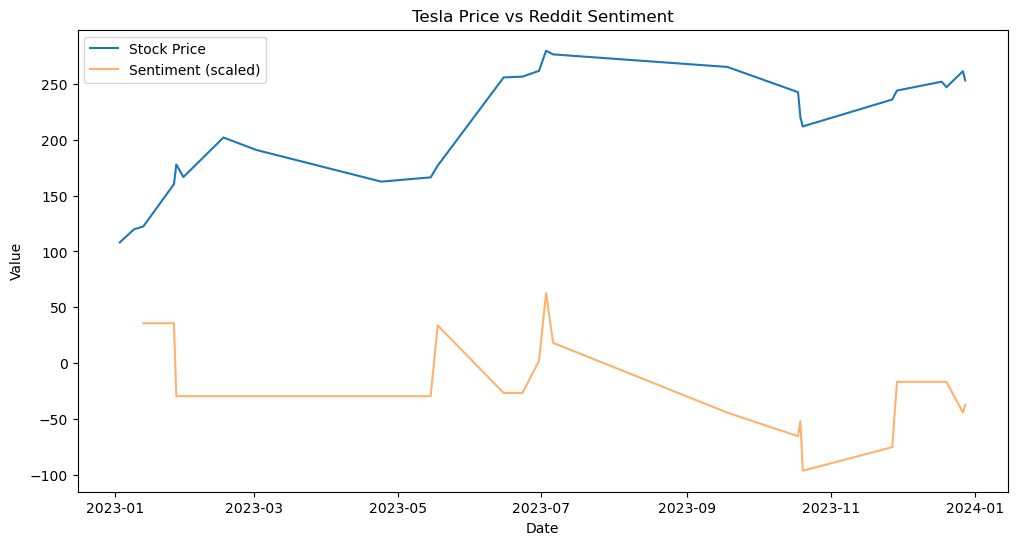

In [76]:
#Graph for Tesla stock price to daily Reddit sentiment
plot_data = merged_df.dropna(subset=['Close_TSLA', 'Sentiment']).copy()
plot_data['SmoothedSentiment'] = plot_data['Sentiment'].rolling(3).mean()

plt.figure(figsize=(12, 6))
plt.plot(plot_data.index, plot_data['Close_TSLA'], label='Stock Price')
plt.plot(plot_data.index, plot_data['SmoothedSentiment'] * plot_data['Close_TSLA'].max(), label='Sentiment (scaled)', alpha=0.6)
plt.title('Tesla Price vs Reddit Sentiment')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [78]:
# Get today's date
today = datetime.today().date()

# Collect Reddit posts from today
posts_today = []
for post in reddit.subreddit("wallstreetbets").search("Tesla", limit=100):
    post_date = datetime.utcfromtimestamp(post.created_utc).date()
    if post_date == today:
        posts_today.append(post.title)

# Analyze sentiment
sentiments = [analyzer.polarity_scores(title)['compound'] for title in posts_today]
today_sentiment = sum(sentiments) / len(sentiments) if sentiments else 0

# Print today's sentiment score
print("🧠 Today's Reddit Sentiment Score:", today_sentiment)

# Predict using trained model
prediction = model.predict([[today_sentiment]])

# Get next trading day (skip weekends)
def get_next_trading_day(start_date=None):
    if start_date is None:
        start_date = datetime.today().date()
    next_day = start_date + timedelta(days=1)
    while next_day.weekday() >= 5:  # 5 = Saturday, 6 = Sunday
        next_day += timedelta(days=1)
    return next_day

next_trading_day = get_next_trading_day()

# Final Prediction Printout
print(f"📅 Tomorrow's Trading Day: {next_trading_day}")
print(f"📈 Prediction for {next_trading_day}: {'🔺 UP' if prediction[0] == 1 else '🔻 DOWN'}")

🧠 Today's Reddit Sentiment Score: 0
📅 Tomorrow's Trading Day: 2025-06-20
📈 Prediction for 2025-06-20: 🔺 UP


/var/folders/yz/c85pt_fs2c36sr4h_scpn7280000gn/T/ipykernel_21319/2571581591.py:7: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  post_date = datetime.utcfromtimestamp(post.created_utc).date()
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
